In [ ]:
import warnings
warnings.filterwarnings("ignore")
from scipy import ndimage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import  ImageDataGenerator, load_img
from keras.layers import Dense,Flatten,BatchNormalization,MaxPooling2D,Conv2D,Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Model
from sklearn.metrics import classification_report , confusion_matrix
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
valid_df = pd.read_csv('/data/Mura/MURA-v1.1/valid.csv')
train_df = pd.read_csv('/data/Mura/MURA-v1.1/train_augmented.csv')

In [ ]:
valid_df['label'] = valid_df['label'].astype(str)
train_df['label'] = train_df['label'].astype(str)

In [ ]:
valid_df

,path,label,BodyPart,diagnosis,bodypart_lable
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,fracture_in_wrist,6
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,fracture_in_wrist,6
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,fracture_in_wrist,6
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,fracture_in_wrist,6
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,XR_WRIST,fracture_in_wrist,6
...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0,XR_FINGER,No_fracture_in_finger,1
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0,XR_FINGER,No_fracture_in_finger,1
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0,XR_FINGER,No_fracture_in_finger,1
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0,XR_FINGER,No_fracture_in_finger,1


In [ ]:
test_generator = datagen.flow_from_dataframe(dataframe=valid_df, directory='/data/',
                                              x_col="path", y_col="label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=False)

Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory='/data/',
                                              x_col="path", y_col="label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=32, shuffle=True)

Found 220848 validated image filenames belonging to 2 classes.


# Modle

In [ ]:
part = 'all'

This TensorFlow code snippet is designed to build and compile a convolutional neural network (CNN) for binary classification tasks, leveraging the pre-trained InceptionV3 architecture as a base model, and employing a distributed training strategy for efficiency. Below is a breakdown of the code:

1. **Distributed Strategy**:
   - `strategy = tf.distribute.MirroredStrategy()`: Initializes a mirrored strategy for distributed training. This strategy supports synchronous training across multiple GPUs on one machine, effectively mirroring the model's variables across all the processors. Each processor computes gradients locally and then they are aggregated across all processors to update the model.

2. **Imports and Setup**:
   - The necessary TensorFlow modules, including regularizers for applying penalties on layer parameters during optimization, and the Adam optimizer, are imported. Also, the InceptionV3 model is imported from TensorFlow's application module.

3. **Model Building within Distributed Strategy Scope**:
   - `with strategy.scope()`: Indicates that the model building and compilation will happen within the context of the defined distributed strategy to ensure the model is properly distributed for training.
   - The learning rate for the optimizer is set to a very small value (1e-5) to make the training process more gradual and potentially more precise.
   - The InceptionV3 model is loaded without its top layer (`include_top=False`) to allow custom layers to be added for the specific binary classification task. It's configured to expect input images of size 300x300 pixels with 3 color channels (RGB).
   - All layers in the InceptionV3 base model are set to be trainable (`layer.trainable = True`), allowing their weights to be updated during training.
   - A global average pooling layer is added to reduce the dimensionality of the features extracted by InceptionV3, followed by a dense layer with 2056 units and ReLU activation function. This layer also applies L1 and L2 regularization to help prevent overfitting by penalizing large weights.
   - A dropout layer with a rate of 0.5 is used to further combat overfitting by randomly setting input units to 0 during training, which helps to make the model more robust and prevents it from relying too much on any one node.
   - Another dense layer with 32 units and ReLU activation function is added before the output layer.
   - The output layer consists of a single neuron with a sigmoid activation function, making it suitable for binary classification tasks.

4. **Model Compilation**:
   - The model is compiled with the Adam optimizer (using the previously defined learning rate), binary crossentropy loss function (suitable for binary classification problems), and accuracy as the metric for evaluation.

5. **Model Summary**:
   - Finally, `model.summary()` is called to print a summary representation of the model, including the layers and their shapes, which helps in understanding the architecture and parameter count of the model.

This code is structured to leverage the power of pre-trained models for transfer learning, allowing for potentially better performance on tasks with limited data, and uses distributed training for efficiency on multi-GPU setups.

In [ ]:
strategy = tf.distribute.MirroredStrategy()
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3

with strategy.scope():
    learning_rate = 0.00001
    optimizer = Adam(learning_rate=learning_rate)
    base_model = InceptionV3( include_top=False, input_tensor=Input(shape=(300, 300, 3)))
    for layer in base_model.layers:
        layer.trainable = True
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dense(2056, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.0000001))(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     



### Base Model: InceptionV3
- **InceptionV3 Architecture**: The model utilizes the InceptionV3 architecture as its base. This architecture is known for its efficiency and effectiveness in image recognition tasks, using a combination of filters of different sizes in parallel to capture information at various scales.
- **Weights**: It seems the model uses pretrained weights on the ImageNet dataset, a large visual database designed for use in visual object recognition software research. This is indicated by the downloading of InceptionV3 weights at the beginning of the code snippet.
- **Input Size**: The model expects input images of size 300x300 pixels with 3 channels (RGB).

### Modifications and Extensions
After the InceptionV3 base, several layers are added to tailor the model for a specific binary classification task:

1. **Global Average Pooling 2D**: Reduces each of the feature maps to a single number by averaging out the values, flattening the output and reducing the number of parameters.

2. **Dense Layer**: A fully connected layer with 2056 units and ReLU activation function is used for high-level reasoning in the neural network. This layer also includes L1 and L2 regularization to help prevent overfitting by penalizing large weights.

3. **Dropout Layer**: A dropout layer with a rate of 0.5 is included to prevent overfitting. It randomly sets input units to 0 at each step during training, which helps to make the model more robust.

4. **Dense Layers**: Further, a dense layer with 32 units and ReLU activation function is used, followed by the output layer.

5. **Output Layer**: The output layer is a dense layer with a single unit and a sigmoid activation function, suitable for binary classification tasks.

### Model Compilation
Although the compilation details are not shown in the output, based on the previous code snippet, the model is compiled with:
- **Optimizer**: Adam, with a learning rate of 0.00001.
- **Loss Function**: Binary crossentropy, which is appropriate for binary classification tasks.
- **Metrics**: Accuracy, to measure the performance of the model.

### Summary
- **Total Parameters**: The model has a total of 26,081,385 parameters.
- **Trainable Parameters**: 26,046,953 of these parameters are trainable, which means they will be updated during the training process.
- **Non-trainable Parameters**: 34,432 parameters are non-trainable, likely because they are part of the InceptionV3 base model that has been set to not update during training.

This setup demonstrates an advanced application of transfer learning, where a pre-trained model (InceptionV3) is fine-tuned for a new, specific task by adding and training additional layers. This approach leverages the general image recognition capabilities of InceptionV3 while customizing the model to perform well on a specific binary classification problem.


### Import Statements
- **matplotlib.pyplot**: Used for plotting graphs, such as training and validation accuracy and loss over epochs.
- **Keras callbacks**: `EarlyStopping`, `ModelCheckpoint`, `LearningRateScheduler`, and `TensorBoard` are imported to provide training enhancements.

### Learning Rate Scheduler Function
- **`decay` function**: This custom function adjusts the learning rate depending on the epoch. For the first epoch, it sets the learning rate to 1e-4. From the second epoch onwards, it reduces the learning rate to 1e-6. This approach helps in fine-tuning the model by reducing the learning rate as training progresses, potentially leading to better model performance.

### Callbacks
1. **EarlyStopping**: Monitors validation loss (`val_loss`) and stops training if there hasn't been an improvement in 3 epochs. It restores the model weights from the epoch with the best validation loss.
   
2. **ModelCheckpoint**: Saves the model after every epoch where there's an improvement in validation loss (`val_loss`), ensuring that the best model is preserved. The saved model file's name includes a variable `part`, likely indicating a part of a dataset or a specific configuration.

3. **LearningRateScheduler**: Uses the `decay` function defined earlier to adjust the learning rate over epochs.

4. **TensorBoard**: Enables visualization of training dynamics in TensorBoard, such as loss and accuracy curves, by logging the data to a specified directory (`logs`).

### Model Training
- The model is trained using a `train_generator`, which is presumably a data generator that yields batches of training data.
- Validation is performed using a `test_generator`, which similarly yields batches of validation data.
- Training goes on for up to 50 epochs, but can be stopped early by the `EarlyStopping` callback.
- The specified callbacks are included in the training process, providing functionality like early stopping, best model checkpointing, dynamic learning rate adjustment, and logging for TensorBoard.

### Plotting Results
- After training, the script plots two graphs:
  - **Model Accuracy**: Shows both training and validation accuracy as a function of epochs.
  - **Model Loss**: Shows both training and validation loss as a function of epochs.
- These plots are crucial for understanding how the model is learning over time and for diagnosing issues like overfitting or underfitting.

### Key Takeaways
- The use of callbacks significantly enhances training by introducing automation in stopping training early if the model is no longer improving, saving the best model automatically, adjusting the learning rate as training progresses, and providing a way to visually monitor the training process.
- Visualizing the training and validation accuracy and loss helps in assessing the model's performance and making informed decisions about further model training or hyperparameter tuning adjustments.

Epoch 1/50
6902/6902 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8295
Epoch 1: val_loss improved from inf to 0.49565, saving model to all_EfficientNetV2S_tf.h5
6902/6902 [==============================] - 2877s 405ms/step - loss: 0.4454 - accuracy: 0.8295 - val_loss: 0.4956 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 2/50
6902/6902 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.9016
Epoch 2: val_loss improved from 0.49565 to 0.43770, saving model to all_EfficientNetV2S_tf.h5
6902/6902 [==============================] - 1966s 285ms/step - loss: 0.2763 - accuracy: 0.9016 - val_loss: 0.4377 - val_accuracy: 0.8433 - lr: 1.0000e-06
Epoch 3/50
6902/6902 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9164
Epoch 3: val_loss did not improve from 0.43770
6902/6902 [==============================] - 1984s 287ms/step - loss: 0.2414 - accuracy: 0.9164 - val_loss: 0.4472 - val_accuracy: 0.8455 - lr: 1.0000e-06
Epoch 4/50

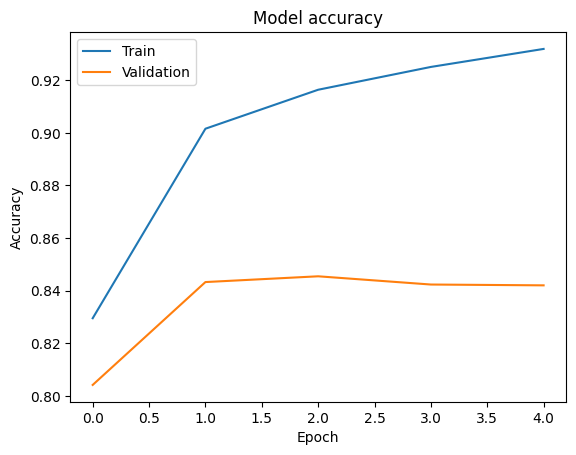

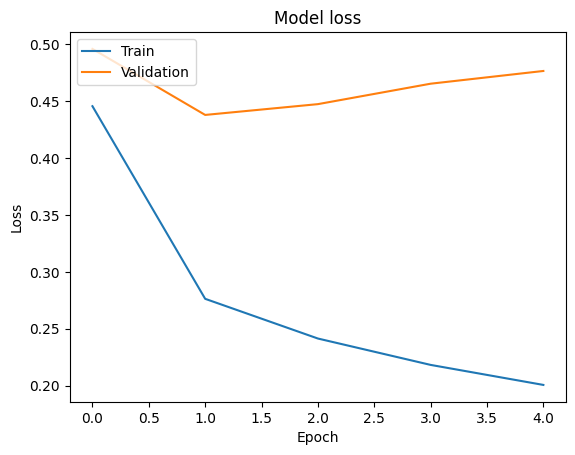

In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

def decay(epoch):
    if epoch < 1:
        return 1e-4
    else:
        return 1e-6

checkpoint_path = '{}_EfficientNetV2S_tf.h5'.format(part)
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # The metric to monitor for early stopping
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,  # Verbosity level
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor='val_loss',  # The metric to monitor for saving the best model
                                   save_best_only=True,  # Save only the best model
                                   mode='min',  # Mode for the 'monitor' metric (e.g., 'min' for loss)
                                   verbose=1)  # Verbosity level

# During model training, include both callbacks in the callbacks list
history = model.fit(train_generator,
          epochs=50,
          validation_data=test_generator,
          callbacks=[early_stopping, model_checkpoint,
                     LearningRateScheduler(decay),
                     TensorBoard(log_dir='logs')])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



### Training Logs
The logs show the training progress for each epoch:

- **Epoch 1/50**:
  - Training loss started at 0.4454, and accuracy was 82.95%.
  - Validation loss was 0.4956 with an accuracy of 80.42% on validation data.
  - The model weights were saved as it was the first epoch, so there was no previous best to compare with.

- **Epoch 2/50**:
  - Training loss decreased to 0.2763, and accuracy improved to 90.16%.
  - Validation loss improved to 0.4377, and validation accuracy increased to 84.33%.
  - The model weights were saved because the validation loss improved from the previous epoch.

- **Epochs 3 to 5**:
  - Training loss and accuracy continued to improve, with loss decreasing to 0.2007 and accuracy increasing to 93.19% by the fifth epoch.
  - However, validation loss did not improve after the second epoch and instead increased, reaching 0.4763 by the fifth epoch. Validation accuracy remained around 84%.
  - The model's performance on the validation set did not improve for three consecutive epochs, triggering the EarlyStopping callback.
  - Training was halted, and the best weights (from epoch 2) were restored due to EarlyStopping.

### Early Stopping
This callback stopped training early because the validation loss did not improve for three epochs, which is the 'patience' parameter set in the `EarlyStopping` callback. By restoring the best model weights, it ensures that the model does not overfit to the training data and that the best performing model is retained.

### Model Accuracy and Loss Plots
The plots visualize the training and validation accuracy and loss:

1. **Model Accuracy Plot**:
   - The training accuracy increases steadily over epochs, which is typical as the model learns from the training data.
   - However, the validation accuracy plateaus after an initial increase. This could indicate the model is overfitting to the training data.

2. **Model Loss Plot**:
   - The training loss decreases rapidly, which is consistent with the model learning and improving over time on the training set.
   - Validation loss decreases initially but then starts to increase slightly, further suggesting that the model might be overfitting to the training data, as it's not generalizing as well to the validation set.

### Implications
The model is getting better at predicting the training data but not showing the same level of improvement on the validation data. This discrepancy can be due to overfitting, where the model is learning patterns specific to the training data that do not generalize to new, unseen data.

To mitigate this, you might consider:
- Gathering more varied training data.
- Using regularization techniques more extensively.
- Adjusting the model architecture.
- Implementing data augmentation to increase the diversity of the training set.
- Tuning other hyperparameters.

The key is to improve the model's generalization to new data, as indicated by the validation loss and accuracy metrics.

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
predictions = model.predict(test_generator)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

true_classes = test_generator.classes


200/200 [==============================] - 23s 98ms/step



1. **`model.predict(test_generator)`**: This line uses the trained model to make predictions on the data provided by `test_generator`. The `test_generator` is typically an instance of `ImageDataGenerator` or similar in Keras, which yields batches of test data. The `predict` function will output a numpy array of predictions, with the shape depending on the model's output layer. If the model is built for binary classification, it will typically output a single probability value per test sample.

2. **`binary_predictions`**: This list comprehension iterates over each prediction in `predictions`. If a prediction is greater than or equal to 0.5, it is interpreted as class 1; otherwise, it's interpreted as class 0. This thresholding converts the probability predictions into binary predictions, which is a common approach for binary classification tasks. The 0.5 threshold means that if the model is at least 50% sure that the input belongs to the positive class, it will classify it as such.

3. **`true_classes = test_generator.classes`**: This line retrieves the true class labels from the `test_generator`. These are the actual classes that the model was supposed to predict, and they are used to evaluate the performance of the model by comparing them with `binary_predictions`.

Together, these lines of code are preparing the outputs of the model and the true labels for further evaluation, where you might calculate metrics such as accuracy, precision, recall, F1 score, etc., to determine how well the model is performing on the test dataset.

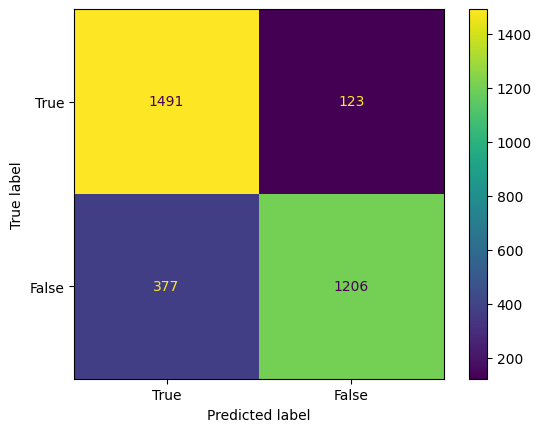

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(true_classes, binary_predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.savefig('Confusion_Matrix_{}2_EfficientNetV2S.png'.format(part))
plt.show()


1. **Importing Libraries**:
   - `matplotlib.pyplot` is used for plotting the confusion matrix.
   - `numpy` is not explicitly used in the snippet but is typically used for numerical operations in Python.
   - `metrics` from `sklearn` is used to calculate the confusion matrix and to display it.

2. **Calculating the Confusion Matrix**:
   - `confusion_matrix = metrics.confusion_matrix(true_classes, binary_predictions)`: This function computes the confusion matrix using the true class labels (`true_classes`) and the predicted binary classes (`binary_predictions`). The true class labels were obtained from the test generator in the previous code snippet, and the predictions were generated by the model.
   
3. **Confusion Matrix Display**:
   - `cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[True, False])`: This creates a `ConfusionMatrixDisplay` object, which is used to display the confusion matrix. The `display_labels` argument specifies the labels of the matrix; in this case, it's a binary classification, so the labels are `True` and `False`.

4. **Plotting and Saving the Confusion Matrix**:
   - `cm_display.plot()`: This method generates the plot for the confusion matrix.
   - `plt.savefig('Confusion_Matrix_{}2_EfficientNetV2S.png'.format(part))`: This line saves the plot as an image file. The filename suggests that the saved confusion matrix relates to a part (denoted by `{}` which is filled with the variable `part`) of an experiment or a subset of the dataset, and is specifically for the "EfficientNetV2S" model or variant.
   - `plt.show()`: This command displays the plot in an output cell within a Jupyter notebook or a Python environment capable of rendering plots.

The image you've provided shows the confusion matrix that likely resulted from running this code. Here's what it tells us:

- **True Positives (Top Left Square, Yellow)**: The model correctly predicted the positive class 1491 times.
- **False Negatives (Top Right Square, Purple)**: The model incorrectly predicted the negative class when it was actually the positive class 123 times.
- **False Positives (Bottom Left Square, Blue)**: The model incorrectly predicted the positive class when it was actually the negative class 377 times.
- **True Negatives (Bottom Right Square, Green)**: The model correctly predicted the negative class 1206 times.

This confusion matrix is useful for understanding the model's performance beyond simple accuracy. It provides insights into the types of errors the model is making. For instance, it might be more conservative, leading to more false negatives, or it might be more liberal, leading to more false positives. Adjusting the classification threshold can balance these if necessary.

In [ ]:
TP = confusion_matrix[1, 1]
TN = confusion_matrix[0, 0]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]

# Calculate Accuracy
accuracy = (TP + TN) / float(TP + TN + FP + FN)

# Calculate Precision
precision = TP / float(TP + FP)

# Calculate Recall
recall = TP / float(TP + FN)

# Calculate Specificity
specificity = TN / float(TN + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)


Accuracy: 0.8436033781670316
Precision: 0.90744920993228
Recall: 0.7618445988629186
Specificity: 0.9237918215613383
F1 Score: 0.8282967032967032


1. **Importing Libraries**:
   - `matplotlib.pyplot` is used for plotting the confusion matrix.
   - `numpy` is not explicitly used in the snippet but is typically used for numerical operations in Python.
   - `metrics` from `sklearn` is used to calculate the confusion matrix and to display it.

2. **Calculating the Confusion Matrix**:
   - `confusion_matrix = metrics.confusion_matrix(true_classes, binary_predictions)`: This function computes the confusion matrix using the true class labels (`true_classes`) and the predicted binary classes (`binary_predictions`). The true class labels were obtained from the test generator in the previous code snippet, and the predictions were generated by the model.
   
3. **Confusion Matrix Display**:
   - `cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[True, False])`: This creates a `ConfusionMatrixDisplay` object, which is used to display the confusion matrix. The `display_labels` argument specifies the labels of the matrix; in this case, it's a binary classification, so the labels are `True` and `False`.

4. **Plotting and Saving the Confusion Matrix**:
   - `cm_display.plot()`: This method generates the plot for the confusion matrix.
   - `plt.savefig('Confusion_Matrix_{}2_EfficientNetV2S.png'.format(part))`: This line saves the plot as an image file. The filename suggests that the saved confusion matrix relates to a part (denoted by `{}` which is filled with the variable `part`) of an experiment or a subset of the dataset, and is specifically for the "EfficientNetV2S" model or variant.
   - `plt.show()`: This command displays the plot in an output cell within a Jupyter notebook or a Python environment capable of rendering plots.

The image you've provided shows the confusion matrix that likely resulted from running this code. Here's what it tells us:

- **True Positives (Top Left Square, Yellow)**: The model correctly predicted the positive class 1491 times.
- **False Negatives (Top Right Square, Purple)**: The model incorrectly predicted the negative class when it was actually the positive class 123 times.
- **False Positives (Bottom Left Square, Blue)**: The model incorrectly predicted the positive class when it was actually the negative class 377 times.
- **True Negatives (Bottom Right Square, Green)**: The model correctly predicted the negative class 1206 times.

This confusion matrix is useful for understanding the model's performance beyond simple accuracy. It provides insights into the types of errors the model is making. For instance, it might be more conservative, leading to more false negatives, or it might be more liberal, leading to more false positives. Adjusting the classification threshold can balance these if necessary.

- Accuracy: 0.8436033781670316
- Precision: 0.90744920993228
- Recall: 0.7618445988629186
- Specificity: 0.9237918215613383
- F1 Score: 0.8282967032967032

In [ ]:
from sklearn.metrics import cohen_kappa_score

def calculate_kappa(y_true, y_pred):
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa

In [ ]:
kappa = calculate_kappa(true_classes, binary_predictions)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.6866945639497849


- Kappa = 1: There is perfect agreement between the true classes and the predictions made by the model.
- Kappa = 0: The agreement is equivalent to chance.
- Kappa < 0: There is less agreement than would be expected by chance, indicating systematic disagreement.
- 0 < Kappa < 1: There is partial agreement, with a higher value indicating stronger agreement.
This measure is particularly useful when dealing with imbalanced classes, where a high accuracy could be misleading. It adjusts for the imbalance by considering the agreement that could happen by random chance.

In [ ]:
import numpy as np
import pandas as pd


predictions = model.predict(test_generator)


predictions_df = pd.DataFrame(predictions, columns=['Probability'])
predictions_df['Predicted Label'] = np.where(predictions_df['Probability'] > 0.5, 1, 0)  # Assuming threshold of 0.5
predictions_df['True Label'] = test_generator.labels
predictions_df['Body Part'] = valid_df['BodyPart']  # Assuming 'Body Part' is a column in your DataFrame


grouped = predictions_df.groupby('Body Part')


accuracy_by_body_part = grouped.apply(lambda x: (x['True Label'] == x['Predicted Label']).mean())

print(accuracy_by_body_part)


200/200 [==============================] - 19s 92ms/step
Body Part
XR_ELBOW       0.868817
XR_FINGER      0.791757
XR_FOREARM     0.837209
XR_HAND        0.795652
XR_HUMERUS     0.913194
XR_SHOULDER    0.822380
XR_WRIST       0.886191
dtype: float64


1. **Model Predictions**:
   - `predictions = model.predict(test_generator)`: This uses the `model` to make predictions on the data provided by the `test_generator`. The assumption here is that the `model` is already trained and that the `test_generator` will yield batches of data. The predictions are likely to be in a continuous format represented by probabilities due to the use of a sigmoid activation function in the output layer of the model.

2. **Creating a DataFrame**:
   - A pandas DataFrame, `predictions_df`, is created with the probabilities of the positive class in a column labeled 'Probability'.
   - A new column, 'Predicted Label', is created using numpy's `where` function, which assigns a label of 1 if the probability is greater than 0.5 and 0 otherwise.
   - The true labels are retrieved from the `test_generator` and stored in the 'True Label' column.
   - An additional column, 'Body Part', is added to the DataFrame, which comes from another DataFrame `valid_df`. This suggests that for each prediction, there is an associated body part involved, such as a medical imaging scenario where different X-ray images are classified.

3. **Grouping and Calculating Accuracy**:
   - The DataFrame is grouped by 'Body Part' using `groupby`.
   - The grouped data is then processed to calculate the accuracy for each body part. The lambda function compares the 'True Label' and 'Predicted Label' for equality, sums the total number of true values, and divides by the total number of entries to get the mean, which is the accuracy.
   
4. **Printing Results**:
   - The accuracy for each body part is printed out, showing how well the model performed for each specific type of body part.

The final output is a pandas Series showing the accuracy of the model's predictions for different body parts, with body parts as the index and their corresponding accuracies as the values. For example, the model has an accuracy of approximately 86.88% for 'XR_ELBOW', 79.18% for 'XR_FINGER', and so forth.

This kind of analysis is particularly useful when the performance of a model might vary significantly across different categories within the data, which seems especially relevant in medical imaging where different body parts might present different classification challenges.

In [ ]:
predictions_df

,Probability,Predicted Label,True Label,Body Part
0,0.989373,1,1,XR_WRIST
1,0.948874,1,1,XR_WRIST
2,0.859957,1,1,XR_WRIST
3,0.974342,1,1,XR_WRIST
4,0.991121,1,1,XR_WRIST
...,...,...,...,...
3192,0.023511,0,0,XR_FINGER
3193,0.022414,0,0,XR_FINGER
3194,0.013799,0,0,XR_FINGER
3195,0.044553,0,0,XR_FINGER


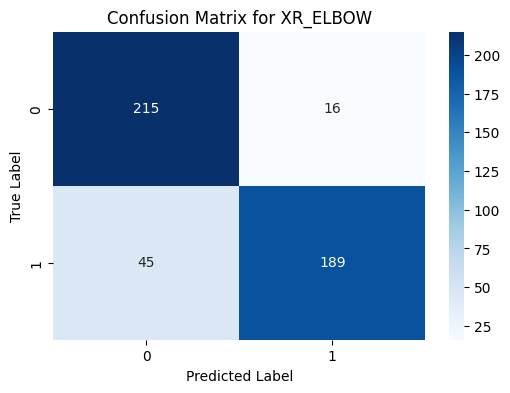

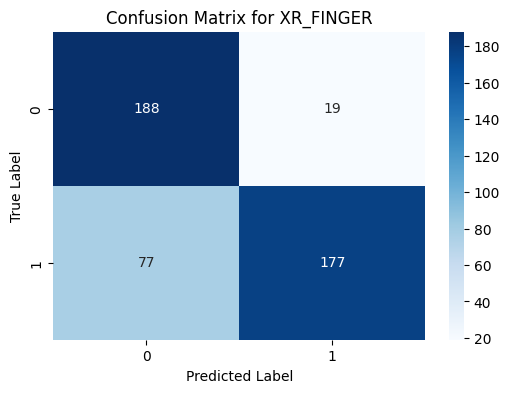

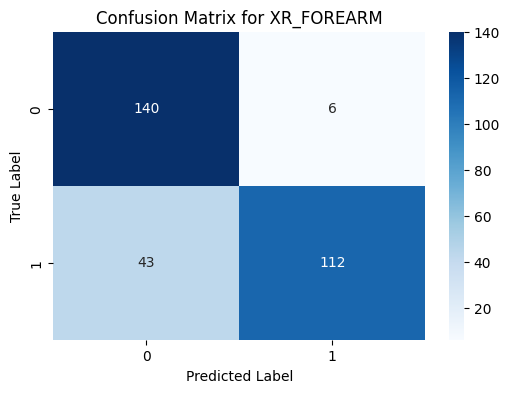

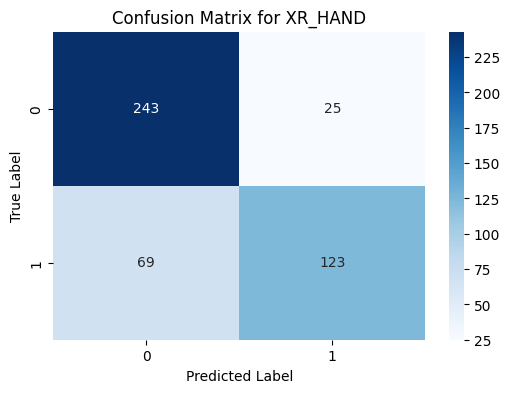

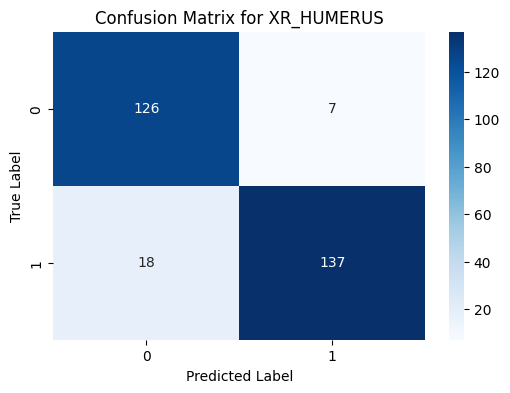

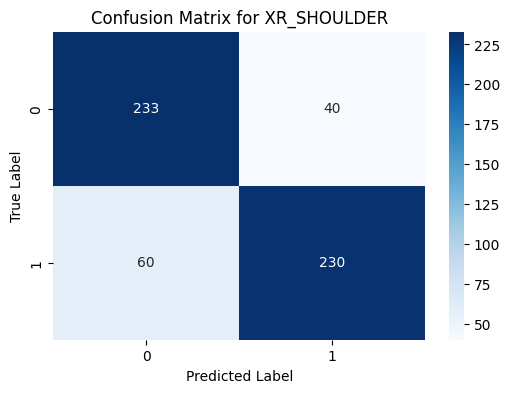

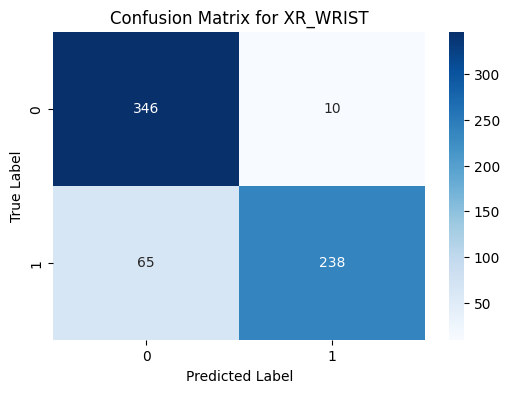

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for body_part, group in predictions_df.groupby('Body Part'):
    cm = confusion_matrix(group['True Label'], group['Predicted Label'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {body_part}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'confusion_matrix_{body_part}.png')  # Save the confusion matrix plot
    plt.show()


In [ ]:
# Open a file for writing
with open("score_{}EfficientNetV2S2.txt".format(part), "w") as file:
    # Write the metrics to the file
    file.write("Accuracy: {}\n".format(accuracy))
    file.write("Precision: {}\n".format(precision))
    file.write("Recall: {}\n".format(recall))
    file.write("Specificity: {}\n".format(specificity))
    file.write("F1 Score: {}\n".format(f1_score))
    file.write("Cohen's Kappa: {}\n".format(kappa))
    file.write("Accuracy by Body Part:\n")
    for body_part, accuracy in accuracy_by_body_part.items():
        file.write("{}: {}\n".format(body_part, accuracy))


print("Metrics saved to 'score_{}.txt'".format(part))

Metrics saved to 'score_all.txt'
